In [2]:
%pylab inline
import pickle
import pprint

import numpy as np
import torch

from ogb.lsc import MAG240MDataset

from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Config

In [3]:
root = '/lfs/rambo/1/vid/mag240m'
dataset = MAG240MDataset(root)

# Data

In [4]:
num_nodes_dict = {
    'paper': dataset.num_papers,
    'author': dataset.num_authors,
    'institution': dataset.num_institutions
}

In [5]:
path = f'{dataset.dir}/col_dict.p'
col_dict = pickle.load(open(path, 'rb'))
edge_types = { index: edge_type for index, edge_type in enumerate(list(col_dict.keys())) }

In [6]:
edge_types

{0: 'paper cites paper',
 1: 'author writes paper',
 2: 'paper rev_writes author',
 3: 'author affiliated_with institution',
 4: 'institution rev_affiliated_with author'}

In [7]:
node_types_start = {}
num_nodes = 0
start = 0

for node_type, node_count in num_nodes_dict.items():
    node_types_start[node_type] = start
    start += node_count
    num_nodes += node_count

In [8]:
train_idx = torch.from_numpy(dataset.get_idx_split('train')) + node_types_start['paper']
y_train = torch.from_numpy(dataset.paper_label[train_idx])
y_train_all = np.zeros((num_nodes,))
y_train_all[train_idx] = y_train + 1

# Heterogeneous Random Walks

In [9]:
path = f'{dataset.dir}/random_walks_nodes.pt'
random_walks_nodes = torch.load(path)
path2 = f'{dataset.dir}/random_walks_edge_types.pt'
random_walks_edge_types = torch.load(path2)

In [11]:
number_of_walks = random_walks_nodes.shape[0]
walk_length = random_walks_nodes.shape[1] - 1

In [12]:
labels = torch.from_numpy(y_train_all[torch.flatten(random_walks_nodes)].reshape(-1, walk_length + 1))
edge_types_counter = { edge_type: 0 for edge_type in edge_types.keys() }
metapath_counter_analysis = np.zeros((labels.shape[0], len(edge_types.values())))

In [13]:
walks_limit = 25000

for i in range(walks_limit):
    start_label = labels[i, 0]
    same_label = labels[i] == start_label
    inds = torch.nonzero(same_label, as_tuple=True)[0]

    if inds.shape[0] == 1:
        if i > 0:
            metapath_counter_analysis[i] = metapath_counter_analysis[i - 1]
        continue
    
    for j in range(inds.shape[0] - 1):
        if random_walks_nodes[i, inds[j]] == random_walks_nodes[i, inds[j+1]]:
            continue
        else:
            between_edge_types = random_walks_edge_types[i, inds[j]:inds[j+1]]        
            between_edge_types = torch.unique_consecutive(between_edge_types)
            
            for edge_type in edge_types.keys():
                if str(edge_type) in str(between_edge_types):
                    edge_types_counter[edge_type] += 1
            
            
#         elif inds[j] + 1 == inds[j+1]:
#             metapath_counter['direct'] += 1
            
#             node_types_counter[0] += 1
#         else:
#             between_types = types[i, inds[j]+1:inds[j+1]]
#             between_types = torch.unique_consecutive(between_types)
#             metapath_counter[str(between_types)] += 1
            
#             for node_type in node_types.keys():
#                 if str(node_type) in str(between_types):
#                     node_types_counter[node_type] += 1
#                     # should we have break here?
    
    # update analysis
    normalized_edge_types_counter = { key: value / sum(list(edge_types_counter.values())) for key, value in edge_types_counter.items() }
    keys, values = zip(*normalized_edge_types_counter.items())
    metapath_counter_analysis[i, keys] = values

/afs/cs.stanford.edu/u/vid/mag240m/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars


In [14]:
print(edge_types_counter)
print(metapath_counter_analysis[:walks_limit])

{0: 3385, 1: 2862, 2: 2862, 3: 46, 4: 46}
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.36789479 0.31105315 0.31105315 0.00499946 0.00499946]
 [0.36789479 0.31105315 0.31105315 0.00499946 0.00499946]
 [0.36789479 0.31105315 0.31105315 0.00499946 0.00499946]]


In [15]:
path = f'{dataset.dir}/edge_types_counter.p'
path2 = f'{dataset.dir}/metapath_counter_analysis.p'

pickle.dump(edge_types_counter, open(path, 'wb'), protocol=4)
pickle.dump(metapath_counter_analysis[:walks_limit], open(path2, 'wb'), protocol=4)

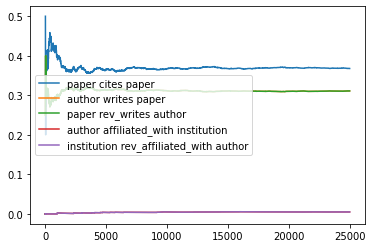

In [16]:
plt.plot(np.arange(walks_limit), metapath_counter_analysis[:walks_limit], label=edge_types.values())
plt.legend()

In [18]:
metapath_counter_analysis[walks_limit - 1]

array([0.36789479, 0.31105315, 0.31105315, 0.00499946, 0.00499946])